# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [ ]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import zarr, copick
from tqdm import tqdm
import napari
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.io.writers as write
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import gc
import concurrent.futures

gc.enable()

In [2]:
torch._dynamo.config.cache_size_limit = 64

In [3]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [4]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 2,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 3,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 4,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 5,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media

# Prepare the dataset
## 1. Get copick root

In [5]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
#tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [6]:
root

CopickRoot(user_id=None, len(pickable_objects)=None, len(runs)=None) at 0x73cd889af3e0

In [7]:
# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            image = tomogram.numpy()
            target = np.zeros(image.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id='curation')
                if len(pick):
                    target = segmentation_from_picks.from_picks(pick[0],
                                                                target,
                                                                target_objects[pickable_object.name]['radius'] * 0.5,
                                                                target_objects[pickable_object.name]['label']
                                                               )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|█████████████████████████████████████████████| 7/7 [00:14<00:00,  2.06s/it]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [8]:
data_dicts = []
for run in tqdm(root.runs):
    tomo = run.get_voxel_spacing(voxel_size)#.get_tomograms(tomo_type)[0].numpy()
    for tomogram in tomo.tomograms:
        tomo_type = tomogram.tomo_type
        image = tomogram.numpy()
        segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
        data_dicts.append({"tomo_type":tomo_type, "image": image, "label": segmentation})
    
print(np.unique(data_dicts[0]['label']))

100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.61s/it]


[0 1 2 3 4 5]


In [9]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label'])

In [10]:
data_dicts[0]['label'].shape

(184, 630, 630)

In [11]:
len(data_dicts)

28

## 4. Visualize the tomogram and painted segmentation from ground-truth picks

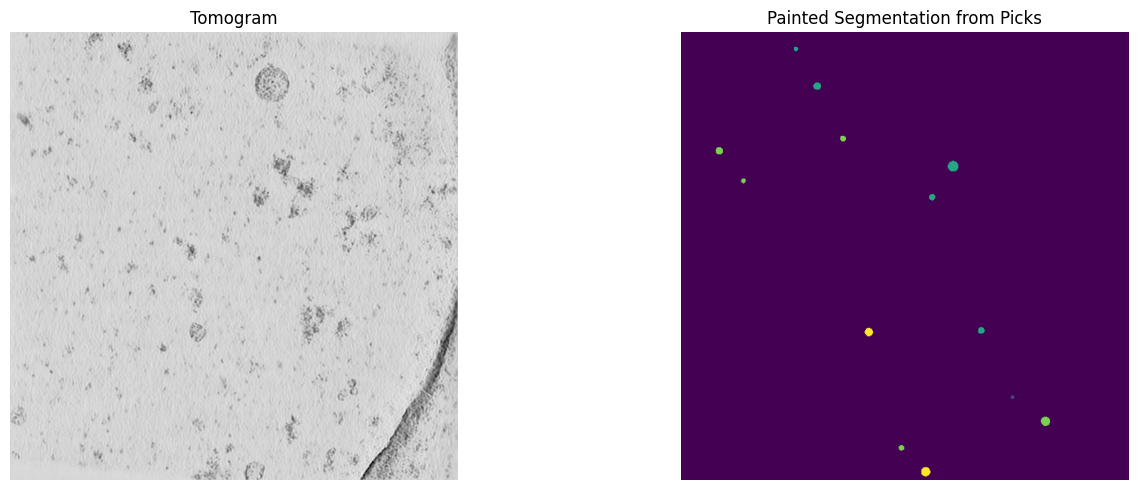

In [12]:
# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

# Simulated data prep

In [13]:
simulated_data_path = '../../czii_downloaded_data/simulated_training_data/'

In [14]:
simulated_experiments_list = [f for f in os.listdir(simulated_data_path) if 'TS_' in f]
simulated_experiments_list

['TS_26',
 'TS_13',
 'TS_22',
 'TS_17',
 'TS_1',
 'TS_24',
 'TS_19',
 'TS_4',
 'TS_6',
 'TS_23',
 'TS_2',
 'TS_16',
 'TS_14',
 'TS_20',
 'TS_18',
 'TS_0',
 'TS_21',
 'TS_3',
 'TS_9',
 'TS_7',
 'TS_10',
 'TS_11',
 'TS_25',
 'TS_12',
 'TS_15',
 'TS_5',
 'TS_8']

In [15]:
particle_info = {
    "apo-ferritin": {"label": 1, "radius": 60},
    "beta-galactosidase": {"label": 2, "radius": 90},
    "ribosome": {"label": 3, "radius": 150},
    "thyroglobulin": {"label": 4, "radius": 130},
    "virus-like-particle": {"label": 5, "radius": 135}
}

In [16]:
def create_masks(image, locations_df):
    shape = image.shape
    volume = np.zeros(shape, dtype=np.uint8)

    for i in range(locations_df.shape[0]):
        center = (locations_df.loc[i, 'z'], locations_df.loc[i, 'y'], locations_df.loc[i, 'x'])
        radius = locations_df.loc[i, 'radius'] / 10 * 0.5
        intensity = locations_df.loc[i, 'label']

        z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
        
        mask = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2 <= radius**2

        volume[mask] = intensity

    return volume

In [17]:
particle_name_dict = {
    'ferritin':'apo-ferritin',
    'galacto':'beta-galactosidase',
    'ribosome':'ribosome',
    'thyro':'thyroglobulin',
    'vlp':'virus-like-particle'
}

In [18]:
def process_experiment(experiment):
    """Process a single experiment in parallel"""
    # Load tomogram data
    tomogram_path = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Tomograms/100/{experiment}.zarr'
    tomogram = zarr.open(tomogram_path, mode='r')[0].__array__()
    
    location_dfs_list = []
    annotations_base = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/'
    
    # Process location files
    for location_folder in os.listdir(annotations_base):
        location_dir = os.path.join(annotations_base, location_folder)
        for location_file in os.listdir(location_dir):
            if 'orientedpoint.ndjson' not in location_file:
                continue
                
            # Determine particle type
            particle_type = None
            for key in particle_name_dict.keys():
                if key in location_file:
                    particle_type = particle_name_dict[key]
                    break
            if not particle_type:
                continue
                
            # Process NDJSON file
            label = particle_info[particle_type]['label']
            radius = particle_info[particle_type]['radius']
            file_path = os.path.join(location_dir, location_file)
            
            location_df = pd.read_json(file_path, lines=True)
            location_df['x'] = location_df['location'].map(lambda x: x['x'])
            location_df['y'] = location_df['location'].map(lambda x: x['y'])
            location_df['z'] = location_df['location'].map(lambda x: x['z'])
            location_df['label'] = label
            location_df['radius'] = radius
            
            location_dfs_list.append(location_df)
    
    # Create mask and return result
    if location_dfs_list:
        all_particle_locations_df = pd.concat(location_dfs_list, ignore_index=True)
        mask_image = create_masks(tomogram, all_particle_locations_df)
        return {"tomo_type": 'Unknown', "image": tomogram, "label": mask_image}
    return None

def append_simulation_data():
    global data_dicts
    max_workers = os.cpu_count() // 2  # Use half the available cores to prevent memory issues
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all experiments for processing
        futures = [executor.submit(process_experiment, exp) for exp in simulated_experiments_list]
        
        # Collect results as they complete
        for future in tqdm(concurrent.futures.as_completed(futures), 
                         total=len(simulated_experiments_list),
                         desc="Processing experiments"):
            result = future.result()
            if result:
                data_dicts.append(result)

In [19]:
append_simulation_data()

Processing experiments: 100%|███████████████████| 27/27 [12:44<00:00, 28.32s/it]


In [20]:
len(data_dicts)

55

## 5. Prepare dataloaders

In [21]:
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric

In [22]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

In [23]:
import random

numbers = list(range(len(data_dicts)))
random_numbers = random.sample(numbers, int(len(data_dicts)/5))

print(random_numbers)

[25, 36, 3, 2, 16, 26, 27, 18, 10, 24, 40]


In [24]:
val_files = []
train_files = []
for i in range(len(data_dicts)):
    if i in random_numbers:
        val_files.append(data_dicts[i])
    else:
        train_files.append(data_dicts[i])

In [25]:
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

Number of training samples: 44
Number of validation samples: 11


In [26]:
num_classes = 6 # number of particles (5) + background (1)

In [27]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=num_classes,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
        allow_missing_keys=True
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

Loading dataset: 100%|██████████████████████████| 11/11 [00:01<00:00,  9.64it/s]


## Model setup

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
#loss_function = TverskyLoss(include_background=False, to_onehot_y=True, softmax=True, alpha=16/17, beta=1/17)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

cuda


In [29]:
class FBetaLoss(nn.Module):
    def __init__(self, beta=4, eps=1e-6, class_weights=None, enzyme_classes=5):
        super().__init__()
        self.beta = beta
        self.eps = eps
        self.enzyme_classes = enzyme_classes
        
        self.class_weights = class_weights or {
            'apo-ferritin': 1,
            'beta-galactosidase': 2,
            'ribosome': 1,
            'thyroglobulin': 2,
            'virus-like-particle': 1,
        }
        self.weight_tensor = torch.tensor(
            [self.class_weights[k] for k in self.class_weights.keys()],
            dtype=torch.float32
        )

    def forward(self, y_pred, y_true):
        # Convert y_true to proper format
        y_true = y_true.squeeze(1).long()  # Remove channel dim & ensure integer type
        
        y_pred_probs = F.softmax(y_pred, dim=1)
        y_pred_enzymes = y_pred_probs[:, 1:self.enzyme_classes+1, ...]
        
        # One-hot encoding with proper type handling
        y_true_onehot = F.one_hot(y_true, num_classes=6).permute(0, 4, 1, 2, 3).float()
        y_true_enzymes = y_true_onehot[:, 1:self.enzyme_classes+1, ...]

        tp = (y_pred_enzymes * y_true_enzymes).sum(dim=(2, 3, 4))
        fp = (y_pred_enzymes * (1 - y_true_enzymes)).sum(dim=(2, 3, 4))
        fn = ((1 - y_pred_enzymes) * y_true_enzymes).sum(dim=(2, 3, 4))

        precision = tp / (tp + fp + self.eps)
        recall = tp / (tp + fn + self.eps)
        beta2 = self.beta ** 2
        f_beta = (1 + beta2) * (precision * recall) / (beta2 * precision + recall + self.eps)

        weight_tensor = self.weight_tensor.to(y_pred.device)
        weighted_f_beta = f_beta * weight_tensor
        aggregate_f_beta = weighted_f_beta.sum(dim=1) / weight_tensor.sum()
        
        return 1 - aggregate_f_beta.mean()

In [30]:
fbeta_loss_function = FBetaLoss()

In [31]:
class ParticleTverskyCrossEntropyLoss(nn.Module):
    def __init__(self, particle_weights, alpha=16/17, beta=1/17, ce_weight=1.0, tversky_weight=1.0, smooth=1e-6):
        """
        Args:
            particle_weights (torch.Tensor): Weights for 5 particles + background [0.0, 1.0, 2.0, 1.0, 2.0, 1.0]
            alpha: Tversky FP weight (prioritizes recall for beta=4)
            beta: Tversky FN weight
        """
        super().__init__()
        self.ce_weight = ce_weight
        self.tversky_weight = tversky_weight
        self.smooth = smooth
        self.alpha = alpha
        self.beta = beta
        
        # Cross-Entropy with particle weights (background weight=0)
        self.ce = nn.CrossEntropyLoss(weight=particle_weights)
        self.register_buffer('class_weights', particle_weights)  # [6] tensor

    def forward(self, inputs, targets):
        # Ensure targets have the correct shape and dtype
        ce_loss = self.ce(inputs, targets.squeeze(1).long())
    
        # Tversky Loss (3D-compatible)
        num_classes = inputs.shape[1]
        probs = F.softmax(inputs, dim=1)
        targets_onehot = F.one_hot(targets.squeeze(1).long(), num_classes).permute(0, 4, 1, 2, 3).float()  # BCDHW
    
        # Flatten spatial dimensions (3D)
        probs_flat = probs.view(probs.size(0), num_classes, -1)  # [B,6,D*H*W]
        targets_flat = targets_onehot.view(targets_onehot.size(0), num_classes, -1)
    
        # Calculate TP/FP/FN (broadcasted across classes)
        tp = (probs_flat * targets_flat).sum(dim=2)  # [B,6]
        fp = (probs_flat * (1 - targets_flat)).sum(dim=2)
        fn = ((1 - probs_flat) * targets_flat).sum(dim=2)
    
        # Tversky index per class
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)  # [B,6]
        tversky_loss = 1 - tversky
    
        # Apply class weights
        weighted_tversky = tversky_loss * self.class_weights  # [B,6]
        tversky_loss = weighted_tversky.mean()
    
        # Combined loss
        return self.ce_weight * ce_loss + self.tversky_weight * tversky_loss

In [32]:
# Class order: [background, apo-ferritin, beta-galactosidase, ribosome, thyroglobulin, virus-like-particle]
particle_weights = torch.tensor([
    0.0,  # Background (weight=0)
    1.0,  # apo-ferritin
    2.0,  # beta-galactosidase (higher weight)
    1.0,  # ribosome
    2.0,  # thyroglobulin (higher weight)
    1.0   # virus-like-particle
], device='cuda')

tversky_ce_loss_function = ParticleTverskyCrossEntropyLoss(
    particle_weights=particle_weights,
    ce_weight=1.0,  # Balance with Tversky
    tversky_weight=1.0  # Emphasize recall
)

In [33]:
post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
post_label = AsDiscrete(to_onehot=num_classes)

In [34]:
def train(train_loader, model, metrics_function, optimizer, max_epochs=25):
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    model.to('cuda')
    model = torch.compile(model)

    torch.set_float32_matmul_precision('high')
    
    scaler = torch.amp.GradScaler('cuda')
    autocast_dtype = torch.float16    
    
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=autocast_dtype):
                outputs = model(inputs)
                #fbeta_loss = fbeta_loss_function(outputs, labels)
                tversky_ce_loss = tversky_ce_loss_function(outputs, labels)
                #total_loss = fbeta_loss * 0.7 + tversky_ce_loss * 0.3

            scaler.scale(tversky_ce_loss).backward()  
            scaler.step(optimizer)  
            scaler.update() 
            
            epoch_loss += tversky_ce_loss.item()
            #print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)

                    with torch.autocast(device_type='cuda', dtype=autocast_dtype):
                        val_outputs = model(val_inputs)
                        metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                        metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                        
                        
                        # compute metric for current iteration
                        metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', f"3DUNet_Tversky_CE_Loss_Best_Metric_Model_{best_metric:.4f}.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\ncurrent mean recall: {metric:.4f} "
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [35]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 10000
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        #"FBetaLoss": fbeta_loss_function.__class__.__name__,
        "TverskyCELoss": tversky_ce_loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

----------
epoch 1/10000
epoch 1 average loss: 2.5609
saved new best metric model
current epoch: 1 current mean recall per class: 0.0008973, 0.0006236, 0.03834, 0.005155, 0.003462
current mean recall: 0.0097 
best mean recall: 0.0097 at epoch: 1
----------
epoch 2/10000
epoch 2 average loss: 2.1759
saved new best metric model
current epoch: 2 current mean recall per class: 0.0005214, 0.0001963, 0.07922, 0.005049, 0.008575
current mean recall: 0.0187 
best mean recall: 0.0187 at epoch: 2
----------
epoch 3/10000
epoch 3 average loss: 1.9847
current epoch: 3 current mean recall per class: 0.004301, 0.0002914, 0.07085, 0.004686, 0.01018
current mean recall: 0.0181 
best mean recall: 0.0187 at epoch: 2
----------
epoch 4/10000
epoch 4 average loss: 1.9155
saved new best metric model
current epoch: 4 current mean recall per class: 0.004316, 0.000167, 0.08197, 0.003393, 0.008953
current mean recall: 0.0198 
best mean recall: 0.0198 at epoch: 4
----------
epoch 5/10000
epoch 5 average loss: 1

KeyboardInterrupt: 

**Note:** Code taken from the official CZ Imaging Institute's official github page.